<!-- # Overview
- Project
    - data engineer 
        - keep acceptable sessions
        - create prediction classes and eliminate end of each session
        - make same input size for rnn
        - add features if this is suitable
    - code each rnn
        - vanilla rnn
        - lstm
        - gru -->

# Overview
- Data Engineering
    - Load Data
    - Initial Data Examination
    - Dataset for Sessions for Entire Session Prediction Problem
        - Remove inacceptable sessions
        - add label
    - (Dataset for Sessions for Early Session Prediction Problem)
        - Remove inacceptable sessions
        - add label
    - Handle NaN Values
    - Feature Encoding
    - Feature Creation
    - Put into Acceptable Input Form
        - Scale Features
        - Padding
        - (Word Embedding)
    - Create Dataloader
- Data Analysis
    - plots

- Modelling
    - Train-Test-Split
    - RNN
        - Model Def
        - Model Training
    - LSTM
        - Model Def
        - Model Training
    - GRU
        - Model Def
        - Model Training
    - (Transformer Model Def)
        - Transfer Learning/Model Def
        - Model Training
        
- Evaluation and Comparison of Models
    - Numerical Evalutaion Metrics
        - AUC and F! Score
       - (Plotting number results comparing each as parameters change)
    - Plotted Evaluation Metrics
        - ROC Curve

# Questions
- 

# Imports

In [375]:
# manipulating data
import pandas as pd
import numpy as np

# Neural Networks
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.optim as optim
from torch.autograd import Variable

# Evaluation
from torchmetrics import F1Score
from torchmetrics.functional import auc
from torchmetrics import ConfusionMatrix

# handling time data
import time # for timestamps
import datetime

# data analysis
import matplotlib.pyplot as plt 

#
import math



# Data Engineering
#### Will be done with Pandas

## Load Data

In [2]:
# global path to data (varies for user)
data_path = '/Users/jonathanwozny/Documents/GraduateSchool/Fall2022/CAP6617/Project/shopper_intent_prediction/release_10_23_2020.csv'

# load dataset
df = pd.read_csv(data_path)


In [3]:
# get column names
col_names = [c for c in df.columns]
features = col_names[:-1]

# sepearate column names into categorical and numerical
cat_cols = []
numer_cols = []

for col in col_names:
    if df[col].dtype == 'O':
        cat_cols.append(col)
    else:
        numer_cols.append(col)

## Initial Data Examination

In [4]:
df.head()

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,NaN,NaN,1544469996111,da99729886aff70a02733b6cd69ee7df35622d9302347e...
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,NaN,NaN,1545737959865,e2f7e0cee4272e804f0d323a3513dd01716a5a40ab9abf...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5433611 entries, 0 to 5433610
Data columns (total 6 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   session_id_hash            object
 1   event_type                 object
 2   product_action             object
 3   product_skus_hash          object
 4   server_timestamp_epoch_ms  int64 
 5   hashed_url                 object
dtypes: int64(1), object(5)
memory usage: 248.7+ MB


#### NAN values in each column

In [6]:
df.isna().sum()

session_id_hash                    0
event_type                         0
product_action               2918789
product_skus_hash            3547557
server_timestamp_epoch_ms          0
hashed_url                         0
dtype: int64

#### Value Counts (for reasonable number of classes)

In [7]:
print("Number of Unique Values for each Categoical Column:\n")
num_unique = []
for col in cat_cols:
    num_unique.append(len(df[col].unique()))
    print("{}: ".format(col), num_unique[-1])
    if num_unique[-1] < 100:
        print('\t')
        print(df[col].value_counts())
    print('\n')

Number of Unique Values for each Categoical Column:

session_id_hash:  443660


event_type:  2
	
pageview    4565253
event        868358
Name: event_type, dtype: int64


product_action:  6
	
detail      1640190
add          743363
click         69831
remove        51512
purchase       9926
Name: product_action, dtype: int64


product_skus_hash:  38345


hashed_url:  256598




## Dataset for Sessions for Whole Session Prediction Problem
- Keep sessons with:
    - length >= 5 clicks
    - length <= 155 clicks
- set nan values in actions = 'pageview'
- remove last few actions and add labels

In [8]:
df

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,NaN,NaN,1544469996111,da99729886aff70a02733b6cd69ee7df35622d9302347e...
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,NaN,NaN,1545737959865,e2f7e0cee4272e804f0d323a3513dd01716a5a40ab9abf...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...
...,...,...,...,...,...,...
5433606,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,detail,81001bca02486bcecc944bc88412be729260f00a54d583...,1545571237554,a498ddf07e784d7d00df18a8f51a81e45aedf57ef8a45a...
5433607,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,NaN,NaN,1545571243349,aaf8c8581bfc7373f63dbdde27304c619bc7db1755ec50...
5433608,ffffc776defb14e6ba4c2635ba87251cb414573c,pageview,NaN,NaN,1545748104469,54f2670e3703a7b85cf5015dc130bc6c1011d7f2fce07c...
5433609,ffffce103f74909ba29cc8f4e40d82583b2e1898,pageview,NaN,NaN,1544536113737,f0ba8800a3e7fc0a3ea6904ad219ec44b964658817c52d...


### Keep sessions with length 5 <= L <= 155

In [9]:
maxSeqCutoffSize = 155
minSeqCutoffSize = 5

dfW = df.groupby('session_id_hash')
dfW = dfW.filter(lambda x: (len(x) >= 5 and len(x) <=155))
dfW = dfW.reset_index()
dfW.drop('index', axis=1, inplace = True)

In [10]:
# in same statement
dfW

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
1,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544909049946,5481ac8074c7ecec6818281b0d12cfddfd005667637925...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,bd81fd361f0ae5438cb712c3a4e0344d05c6ebd4b7aae6...,1544909231588,05b9fd85f8201a96bd8dd102ae83288aae394c91fd53d1...
...,...,...,...,...,...,...
4198650,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,NaN,NaN,1545570913853,6ddd53c2e8a4513d63b5393db16475c8aefcfbcea0e7c5...
4198651,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,NaN,NaN,1545571133716,a2494e01b9fdc0cb2ac36472f19f6ace950ba23d043990...
4198652,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,detail,81001bca02486bcecc944bc88412be729260f00a54d583...,1545571171266,a498ddf07e784d7d00df18a8f51a81e45aedf57ef8a45a...
4198653,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,detail,81001bca02486bcecc944bc88412be729260f00a54d583...,1545571237554,a498ddf07e784d7d00df18a8f51a81e45aedf57ef8a45a...


In [11]:
print('Number of unique sessions: {} \n'.format(len(dfW['session_id_hash'].unique())))

Number of unique sessions: 203127 



## Handle NaN Values
- product action
- product_skus_hash

In [12]:
# change to pageview in product_action
dfW.loc[dfW['product_action'].isna(), "product_action"] = 'pageview'

In [13]:
# change NaN to 'None'
dfW.loc[dfW['product_skus_hash'].isna(), "product_skus_hash"] = 'None'


In [14]:
# No values should be NaN
dfW.isna().sum()

session_id_hash              0
event_type                   0
product_action               0
product_skus_hash            0
server_timestamp_epoch_ms    0
hashed_url                   0
dtype: int64

In [15]:
dfW.head()

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
1,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544909049946,5481ac8074c7ecec6818281b0d12cfddfd005667637925...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,bd81fd361f0ae5438cb712c3a4e0344d05c6ebd4b7aae6...,1544909231588,05b9fd85f8201a96bd8dd102ae83288aae394c91fd53d1...


## Feature Creation

### boolean of whether a product is being looked at (for Nan Values in product_skus_hash)

In [16]:
dfW['viewing_product'] = 0
dfW.loc[dfW['product_skus_hash'] != 'None', 'viewing_product'] = 1

### Time sitting on page (time between timestamps)

In [17]:
dfW['time_sitting'] = df.groupby('session_id_hash')['server_timestamp_epoch_ms'].diff().fillna(0)

In [18]:
dfW.head()

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url,viewing_product,time_sitting
0,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...,0,0.0
1,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...,0,0.0
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...,1,0.0
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544909049946,5481ac8074c7ecec6818281b0d12cfddfd005667637925...,0,11861.0
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,bd81fd361f0ae5438cb712c3a4e0344d05c6ebd4b7aae6...,1544909231588,05b9fd85f8201a96bd8dd102ae83288aae394c91fd53d1...,1,188616.0


### Timestamps to Categorical Time Features (i.e. month, day, hour, minutes)

In [19]:
def timestampToFeatures(data, time_col='server_timestamp_epoch_ms'):
    new_date_cols = ['year', 'month', 'day']
    new_time_cols = ['hour', 'minute', 'second']
    
    data['datetime_string'] = data[time_col].apply(lambda x: time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(x/1000)))
    
    data[['date', 'time']] = data['datetime_string'].str.split(' ', expand = True)
    data[new_date_cols] = data['date'].str.split('-', expand = True).astype(int)
    data[new_time_cols] = data['time'].str.split(':', expand = True).astype(int)
    
    data.drop(['datetime_string', 'date', 'time'], axis=1, inplace=True)
    
    return data

In [20]:
dfW = timestampToFeatures(dfW, 'server_timestamp_epoch_ms')

In [21]:
dfW

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url,viewing_product,time_sitting,year,month,day,hour,minute,second
0,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...,0,0.0,2018,12,15,21,20,35
1,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...,0,0.0,2018,12,15,21,20,47
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...,1,0.0,2018,12,15,21,23,55
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544909049946,5481ac8074c7ecec6818281b0d12cfddfd005667637925...,0,11861.0,2018,12,15,21,24,9
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,bd81fd361f0ae5438cb712c3a4e0344d05c6ebd4b7aae6...,1544909231588,05b9fd85f8201a96bd8dd102ae83288aae394c91fd53d1...,1,188616.0,2018,12,15,21,27,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198650,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,pageview,None,1545570913853,6ddd53c2e8a4513d63b5393db16475c8aefcfbcea0e7c5...,0,23421.0,2018,12,23,13,15,13
4198651,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,pageview,None,1545571133716,a2494e01b9fdc0cb2ac36472f19f6ace950ba23d043990...,0,127644.0,2018,12,23,13,18,53
4198652,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,detail,81001bca02486bcecc944bc88412be729260f00a54d583...,1545571171266,a498ddf07e784d7d00df18a8f51a81e45aedf57ef8a45a...,1,50187.0,2018,12,23,13,19,31
4198653,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,detail,81001bca02486bcecc944bc88412be729260f00a54d583...,1545571237554,a498ddf07e784d7d00df18a8f51a81e45aedf57ef8a45a...,1,17317.0,2018,12,23,13,20,37


### Frequency Encoding of the Product

In [22]:
def FreqEncodeCol(data, columns):
    freq_enc_str = 'freq_enc_'
    for col in columns:
        new_col_name = freq_enc_str + col
        freq_enc_smap = (data.groupby(col).size()) / len(data[col])# series mapping
        data[new_col_name] = dfW[col].apply(lambda x : freq_enc_smap[x])
        
        if ((data[col].unique() == 'None').any()):
            data.loc[data[col] != 'None', new_col_name] = data.loc[data[col] != 'None', new_col_name] / (1 - freq_enc_smap['None'])
            data.loc[data[col] == 'None', new_col_name] = 0
    return data

In [23]:
dfW = FreqEncodeCol(dfW, ['product_skus_hash', 'hashed_url'])

In [24]:
dfW

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url,viewing_product,time_sitting,year,month,day,hour,minute,second,freq_enc_product_skus_hash,freq_enc_hashed_url
0,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...,0,0.0,2018,12,15,21,20,35,0.000000,0.002244
1,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...,0,0.0,2018,12,15,21,20,47,0.000000,0.002244
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...,1,0.0,2018,12,15,21,23,55,0.000137,0.000052
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,pageview,None,1544909049946,5481ac8074c7ecec6818281b0d12cfddfd005667637925...,0,11861.0,2018,12,15,21,24,9,0.000000,0.000308
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,bd81fd361f0ae5438cb712c3a4e0344d05c6ebd4b7aae6...,1544909231588,05b9fd85f8201a96bd8dd102ae83288aae394c91fd53d1...,1,188616.0,2018,12,15,21,27,11,0.000159,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198650,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,pageview,None,1545570913853,6ddd53c2e8a4513d63b5393db16475c8aefcfbcea0e7c5...,0,23421.0,2018,12,23,13,15,13,0.000000,0.003274
4198651,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,pageview,None,1545571133716,a2494e01b9fdc0cb2ac36472f19f6ace950ba23d043990...,0,127644.0,2018,12,23,13,18,53,0.000000,0.000047
4198652,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,detail,81001bca02486bcecc944bc88412be729260f00a54d583...,1545571171266,a498ddf07e784d7d00df18a8f51a81e45aedf57ef8a45a...,1,50187.0,2018,12,23,13,19,31,0.000670,0.000257
4198653,ffffc2bce69fd5da3e9998fd5c788450a726ba4d,pageview,detail,81001bca02486bcecc944bc88412be729260f00a54d583...,1545571237554,a498ddf07e784d7d00df18a8f51a81e45aedf57ef8a45a...,1,17317.0,2018,12,23,13,20,37,0.000670,0.000257


## Feature Encoding

### Function to ordinally encode desired columns

In [25]:
def ord_encoder(data, enc_cols, series=False):
    maps = {}
    for col in enc_cols:
        # encoding value for NaN values

        # put all unique values into list
        myList = data[col].unique()

        # dictionary to map values to encoded integers by index
        mapper = dict(map(reversed,enumerate(myList))) 

        # encode values with value > 0 (0 is value used for padding)
        for key in mapper:
            mapper[key] = mapper[key] + 1

        maps[col] = mapper

        # map to encoded values
        data[col] = data[col].apply(lambda x: mapper[x])        
        
    return maps, data

In [26]:
enc_cols = ['session_id_hash', 'event_type', 'product_action', 'product_skus_hash', 'hashed_url']
col_maps, dfW = ord_encoder(dfW, enc_cols)

## Put into Acceptable Input Form

In [27]:
maps = {}
enc_cols = ['product_action']
for col in enc_cols:
    # encoding value for NaN values

    # put all unique values into list
    myList = df[col].unique()

#     # dictionary to map values to encoded integers by index
    mapper = dict(map(reversed,enumerate(myList))) 

    # encode values with value > 0 (0 is value used for padding)
    for key in mapper:
        mapper[key] = mapper[key] + 1

    maps[col] = mapper

#     # map to encoded values
#     data[col] = data[col].apply(lambda x: mapper[x])

### Create Labels

#### Create Labels for Purchase (True) or No Purchase (False)

In [28]:
## this code was here, but not sure what it did

#df['Expected'] = (g['Value1'].transform(lambda x: x.eq(7).any()))&(g['Value2'].transform(lambda x: x.eq(9).any()))

In [98]:
def CreateTwoLabels(data):
    data['Label'] = data.groupby('session_id_hash')['product_action'].transform(lambda x: x.eq(col_maps['product_action']['purchase']).any())
    labels = data.groupby('session_id_hash')['Label'].unique().apply(list)
    data.drop('Label', axis=1, inplace=True)
    
    new_labels = np.empty([labels.shape[0],1])
    for i, v in enumerate(labels):
        new_labels[i] = v[0]
    return new_labels.astype(int)
    

In [99]:
my2Labels = CreateTwoLabels(dfW)

assert(len(my2Labels) == len(dfW['session_id_hash'].unique()))

In [106]:
np.unique(my2Labels, return_counts=True)

(array([0., 1.]), array([194755,   8372]))

#### Create Labels for Purchase, No Purchase, or Abandon Cart

In [100]:
def check_df(data):
  if (data['Label1'] == False and data['Label2'] == False):
    return 0
  elif (data['Label1'] == False and data['Label2'] == True):
    return 1
  else:
    return 2

In [152]:
def CreateThreeLabels(data):
    data['Label1'] = data.groupby('session_id_hash')['product_action'].transform(lambda x: x.eq(col_maps['product_action']['purchase']).any())
    data['Label2'] = data['Label1']
    data.loc[~data['Label1'], 'Label2'] = data.loc[~data['Label1'], ['session_id_hash', 'product_action', 'Label2']].groupby('session_id_hash')['product_action'].transform(lambda x: x.eq(col_maps['product_action']['add']).any())
    data['Label3'] = data.apply(check_df, axis=1)
    labels = data.groupby('session_id_hash')['Label3'].unique().apply(list)
    data.drop(['Label1', 'Label2', 'Label3'], axis=1, inplace=True)
    new_labels = np.empty([labels.shape[0],1])
    for i, v in enumerate(labels):
        new_labels[i] = v[0]
    return new_labels.astype(int)
    

In [153]:
my3Labels = CreateThreeLabels(dfW)
assert(len(my3Labels) == len(dfW['session_id_hash'].unique()))

In [154]:
np.unique(my3Labels, return_counts = True)

(array([0., 1., 2.]), array([164674,  30081,   8372]))

### Scale Desired Columns

In [34]:
def NormalizeCols(data, norm_cols):
    data[norm_cols] = (data[norm_cols]-data[norm_cols].min())/(data[norm_cols].max() - data[norm_cols].min())
    return data


In [295]:
norm_cols = ['time_sitting', 'day', 'hour', 'minute']
dfW = NormalizeCols(dfW, norm_cols)

# Data Analysis

(array([2.510161e+06, 7.728710e+05, 3.248280e+05, 1.707060e+05,
        1.011960e+05, 6.590700e+04, 4.555000e+04, 3.236100e+04,
        2.471600e+04, 1.922100e+04, 1.511700e+04, 1.232500e+04,
        1.009200e+04, 8.543000e+03, 7.252000e+03, 6.062000e+03,
        5.159000e+03, 4.553000e+03, 4.116000e+03, 3.582000e+03,
        3.326000e+03, 2.902000e+03, 2.627000e+03, 2.475000e+03,
        2.242000e+03, 2.092000e+03, 1.978000e+03, 1.740000e+03,
        1.619000e+03, 1.514000e+03]),
 array([0.        , 0.01333333, 0.02666667, 0.04      , 0.05333333,
        0.06666667, 0.08      , 0.09333333, 0.10666667, 0.12      ,
        0.13333333, 0.14666667, 0.16      , 0.17333333, 0.18666667,
        0.2       , 0.21333333, 0.22666667, 0.24      , 0.25333333,
        0.26666667, 0.28      , 0.29333333, 0.30666667, 0.32      ,
        0.33333333, 0.34666667, 0.36      , 0.37333333, 0.38666667,
        0.4       ]),
 <BarContainer object of 30 artists>)

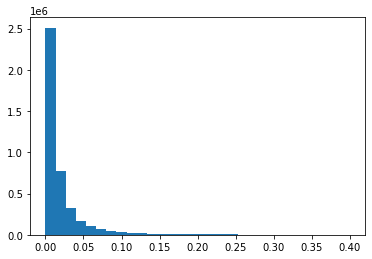

In [297]:
x = dfW.time_sitting
plt.hist(x, bins=30, range=(x.min(), 0.4))

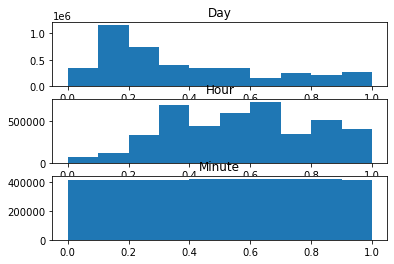

In [298]:
x1 = dfW.day
x2 = dfW.hour
x3 = dfW.minute


# Set the second subplot as active, and make the second plot. 
plt.subplot(3, 1, 1) 
plt.hist(x1) 
plt.title('Day')  

# Make the third plot 
plt.subplot(3, 1, 2) 
plt.hist(x2) 
plt.title('Hour')  

# Make the fourth plot 
plt.subplot(3, 1, 3) 
plt.hist(x3) 
plt.title('Minute') 
   
# Show the figure. 
plt.show()

## Remove Unecessary Columns

In [ ]:
cols_to_drop = ['server_timestamp_epoch_ms', 'product_skus_hash', 'hashed_url', 'year', 'month', 'second']
dfW.drop(cols_to_drop, axis=1, inplace=True)

### Convert to Data Numpy Array (Later to Tensor)

In [300]:
# find the maximum sequence length to pad to
maxSeqLen = dfW.groupby('session_id_hash').count().max().max() # should be 155 or a bit less than 155

# convert to numpy array
# https://stackoverflow.com/questions/65767833/pandas-dataframe-to-tensor
seq_arrays = np.asarray(dfW.groupby(['session_id_hash']).apply(np.array))


### Get Rid of Purchase Actions and all actions after

In [301]:
# arr3D[x][y][z], x = session, y = sequence_row, z is column... z=1 is 'product action'
# this function removes all rows after purchase is made (including purchase row) for 3d numpy array with above dims
def removeRowsAfterPurchase(arr3D, column, value):
    for i, x in enumerate(arr3D):
        for j, y in enumerate(arr3D[i]):
            if (arr3D[i][j][column] == value):
                arr3D[i] = arr3D[i][1:j]
                break
    return arr3D

In [302]:
colName = 'product_action'
colInd = dfW.columns.get_loc(colName)
seq_arrays = removeRowsAfterPurchase(seq_arrays, colInd, col_maps[colName]['purchase'])

### Put into Correct Input Shape
- Input data: RNN should have 3 dimensions. (Batch Size, Sequence Length and Input Dimension) (https://www.analyticsvidhya.com/blog/2021/07/understanding-rnn-step-by-step-with-pytorch/#:~:text=Here%20input%20size%20is%202,otherwise%20it%20will%20be%201.)
    - Batch Size is the number of samples we send to the model at a time. (this is chosen)
    - Sequence Length is the length of the sequence of input data (should be about <= 155)
    - Input Dimension is the number of features or dimensions you are using in your data set (number of columns)

#### Padding and Removing SessionID

In [303]:
# drop first column (session_id_hash)
# pad with zeros at end
for i, seq in enumerate(seq_arrays):
    seq_arrays[i] = np.delete(seq_arrays[i], 0, axis = 1)
    seq_arrays[i] = np.pad(seq_arrays[i], ((0, maxSeqLen - seq_arrays[i].shape[0]),(0,0)), 'constant')

In [304]:
seq_arrays = np.asarray([i for i in seq_arrays])

# Modelling

### Baseline - The baseline would be predicting that nobody will purchase
## THIS SHOULD BE PUT LATER ACTUALLY ONCE CLASSES ARE MADE MORE BALANCED

#### For 2 Labels

In [372]:
np.unique(my2Labels, return_counts = True)[1][0] / len(my2Labels)

0.9587844058150812

#### For 3 Labels

In [373]:
np.unique(my3Labels, return_counts = True)[1][0] / len(my2Labels)

0.8106947870051741

####
- https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm

- There's one additional rule of thumb that helps for supervised learning problems. You can usually prevent over-fitting if you keep your number of neurons below:

𝑁ℎ=𝑁𝑠(𝛼∗(𝑁𝑖+𝑁𝑜))

- 𝑁𝑖 = number of input neurons.
- 𝑁𝑜 = number of output neurons.
- 𝑁𝑠 = number of samples in training data set.
- 𝛼 = an arbitrary scaling factor usually 2-10.

Guy says he geneerally uses 2

#### https://www.reddit.com/r/MachineLearning/comments/4behuh/does_the_number_of_layers_in_an_lstm_network/
Some discussion about what "depth" in recurrent architectures means. Downward skip-connections seem to be the most helpful, but in general skip connections are critical in deep recurrent networks.

#### 
- https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
- usually one hidden layer is fine

### This looks like best tutorial to follow so far (in an article)
- https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
- https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-rnn-for-text-classification-tasks
    - didn't look bad either
- https://docs.wandb.ai/guides/integrations/pytorch
    - logging gradients with wandb

### Youtube Tutorial - Just Like Best One up There
- https://www.youtube.com/watch?v=1vGOQAel2yU&ab_channel=SungKim
- packed sequence

## Train-Test(-Val)-Split and Dataloader

In [305]:
print(len(seq_arrays[:train_sz, :, :]))
print(len(seq_arrays[train_sz:train_sz+val_sz, :, :]))
print(len(seq_arrays[train_sz+val_sz:train_sz+val_sz+test_sz, :, :]))

142189
30469
30469


In [306]:
# number of samples in train, val, test
tot_num_samp = len(seq_arrays)
train_sz = math.ceil(0.7 * tot_num_samp)
val_sz = math.floor(0.15 * tot_num_samp)
test_sz = math.floor(0.15 * tot_num_samp)

# randomize data for splitting
randomize = np.arange(len(seq_arrays))
np.random.shuffle(randomize)
seq_arrays = seq_arrays[randomize]
my2Labels = my2Labels[randomize]
my3Labels = my3Labels[randomize]



# indices to grab separate data
train_val_ind = train_sz+val_sz
train_val_test_ind = train_sz+val_sz+test_sz

# split into train val test (for 2 labels and 3 labels)
train_x, val_x, test_x = seq_arrays[:train_sz, :, :], seq_arrays[train_sz:train_val_ind, :, :], seq_arrays[train_val_ind:train_val_test_ind, :, :]
train_y_2, val_y_2, test_y_2 = my2Labels[:train_sz, :], my2Labels[train_sz:train_val_ind, :], my2Labels[train_val_ind:train_val_test_ind, :]
train_y_3, val_y_3, test_y_3 = my3Labels[:train_sz, :], my3Labels[train_sz:train_val_ind, :], my3Labels[train_val_ind:train_val_test_ind, :]

assert(len(train_x) == train_sz & len(train_y_2) == train_sz & len(train_y_3) == train_sz)
assert(len(val_x) == val_sz & len(val_y_2) == val_sz & len(val_y_3) == val_sz)
assert(len(test_x) == test_sz & len(test_y_2) == test_sz & len(test_y_3) == test_sz)



In [307]:
# see class splits 
print(np.unique(train_y_2, return_counts=True), "should be similar to [136329, 21056, 5860]")
print(np.unique(val_y_2, return_counts=True), "should be similar to [29213, 5860]")
print(np.unique(test_y_2, return_counts=True), "should be similar to [29213, 5860]")

print(np.unique(train_y_3, return_counts=True), "should be similar to [115272, 21056, 5860]")
print(np.unique(val_y_3, return_counts=True),   "should be similar to [24701, 4512, 1255]")
print(np.unique(test_y_3, return_counts=True),  "should be similar to [24701, 4512, 1255]")

print("Data split evenly")


(array([0, 1]), array([136359,   5830])) should be similar to [136329, 21056, 5860]
(array([0, 1]), array([29167,  1302])) should be similar to [29213, 5860]
(array([0, 1]), array([29229,  1240])) should be similar to [29213, 5860]
(array([0, 1, 2]), array([115344,  20954,   5891])) should be similar to [115272, 21056, 5860]
(array([0, 1, 2]), array([24655,  4506,  1308])) should be similar to [24701, 4512, 1255]
(array([0, 1, 2]), array([24675,  4621,  1173])) should be similar to [24701, 4512, 1255]
Data split evenly


In [308]:
# Create dataset from several tensors with matching first dimension
# Samples will be drawn from the first dimension (rows)
train_dataset = TensorDataset( Tensor(train_x), Tensor(train_y_2) )
val_dataset = TensorDataset( Tensor(val_x), Tensor(val_y_2) )
test_dataset = TensorDataset( Tensor(test_x), Tensor(test_y_2) )

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Training Function

In [309]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

### Evaluation

## Vanilla RNN

### Model Definition

In [586]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1):
        super(RNNClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        # self.embedding = (input_size, hidden_size)
        
        # input_size might need to be hidden_size as well
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first = True, dropout = 0)
        # MAYBE NEED TO ADD ANOTHER LINEAR LAYER
        self.linear = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, sequences):

        batch_size = sequences.size(0)
    
        #embedded = self.embedding(sequence)
#         print(sequences.shape)
        
        hidden = self._init_hidden(batch_size)
#         print("hidden1 shape: ", hidden.shape)
        out, hidden = self.rnn(sequences, hidden) # embedded here for sequence if not commented out
    
        output, hidden = self.rnn(sequences)
    
    
#         print("hidden2 shape: ", hidden.shape)
#         print("output1 shape: ", out.shape)
       
        # out = out[:, -1]   # found from online for a certain error, might want to investigate further
                            # refer to this for fix -> i think about three entries down
                            # https://stackoverflow.com/questions/4493554/neural-network-always-produces-same-similar-outputs-for-any-input
       
        # out = out[:, -1, :] # this solution from https://discuss.pytorch.org/t/cross-entropy-loss-target-size-and-output-size-mismatch/99031/8
                            # makes the loss huuuuggee
        
        # https://discuss.pytorch.org/t/valueerror-expected-target-size-32-7-got-torch-size-32/42409/4
            # might have some useful information about this stuff
        
        
        #out = out.contiguous().view(-1, self.hidden_size) # from second resource below
                                                          # doesn't seem to work either
#         print("out1 reshaped: ", out.reshape(-1, hidden_size))  # also doesn't seem to work
#         out = self.linear(out.reshape(-1, hidden_size))
        #scores = torch.nn.CrossEntropyLoss()
    
        hidden.squeeze_(0)
        out = self.linear(hidden)
        
    
#         print("output2 shape: ", out.shape)
        return out, hidden
    
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)
           

In [579]:
# https://github.com/hunkim/PyTorchZeroToAll/blob/master/13_2_rnn_classification.py
# - written with this, use the one below
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/

# TRY THIS
# https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L15/1_lstm.ipynb



### Model Training

#### Training Function
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
    - training with validation as well

In [580]:
# model parameters for instantiation
input_size = seq_arrays.shape[2]
hidden_size = 32
output_size = 2
n_layers = 1

#instantiate model
rnn = RNNClassifier(input_size, hidden_size, output_size, n_layers)

loss_fn = torch.nn.CrossEntropyLoss() # SHOULD USE WEIGHT PARAMETER SINCE UNBALANCED
learning_rate = 0.001

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [581]:
outputs.shape

torch.Size([64, 2])

In [582]:
num_epochs = 5

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #labels = labels.long() # convert to expected target datatype (Long which is equivalent to int here)
        labels = labels.type(torch.LongTensor)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, h = rnn(inputs)
        
#         outputs = outputs[:,154,0:2]
        loss = loss_fn(outputs,labels.view(-1).long())
#         loss = loss_fn(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.182
[2,  2000] loss: 0.172
[3,  2000] loss: 0.171
[4,  2000] loss: 0.171
[5,  2000] loss: 0.171
Finished Training


In [583]:
# correct = 0
total = 0
all_pred = []
all_label = []

# CAN USE TENSOR.TOPK() TO GET THE INDEX OF THE LARGEST OUTPUT

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        # calculate outputs by running images through the network
        outputs, h = rnn(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.reshape(labels, (-1,))).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %'.format("hey"))

Accuracy of the network on the test images: 95 %


#### F1-Score

In [384]:
lb = []
pred = []

for l in labels:
    lb.append(l.int())

for p in predicted:
    pred.append(p.int())

In [ ]:
a_list = [1, 9903, 7876, 9971, 2770, 2435, 10441, 9370, 2]
tmp2 = torch.tensor(a_list, dtype=torch.int)

In [ ]:
f1_rnn = F1Score(num_classes=2)
f1_rnn(pred, lb)

#### Parameters

In [43]:
seq_arrays.shape

(203127, 155, 15)

In [ ]:
# parameters
input_size = seq_arrays.shape[2]
hidden_size = 32
output_size = 2
n_layers = 1
batch_size = 256
n_epochs = 5

# instantiate the model
rnn = RNNClassifier(input_size, hidden_size, output_size, n_layers = 1)

## LSTM

### Model Definition
- can try stacking lstm
- dropout
- bidirectional lstm (isn't really used for predicting the future)
- cnn lstm hybrid

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1):
        super(RNNClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        # self.embedding = (input_size, hidden_size)
        
        # input_size might need to be hidden_size as well
        self.lstm = torch.nn.LSTM(input_size, hidden_size, nonlinearity='relu', batch_first = True, dropout = 0)
        # MAYBE NEED TO ADD ANOTHER LINEAR LAYER
        self.linear = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, sequences):

        batch_size = sequences.size(0)
    
        #embedded = self.embedding(sequence)
        
        hidden = self._init_hidden(batch_size)
        out, hidden = self.rnn(sequences, hidden) # embedded here for sequence if not commented out
        out = out[:, -1]    # found from online for a certain error, might want to investigate further
        out = self.linear(out)
        #scores = torch.nn.CrossEntropyLoss()
        return out, hidden
    
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)

### Model Training

## GRU

### Model Definition

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers = 1):
        super(RNNClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        # self.embedding = (input_size, hidden_size)
        
        # input_size might need to be hidden_size as well
        self.lstm = torch.nn.GRU(input_size, hidden_size, nonlinearity='relu', batch_first = True, dropout = 0)
        # MAYBE NEED TO ADD ANOTHER LINEAR LAYER
        self.linear = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, sequences):

        batch_size = sequences.size(0)
    
        #embedded = self.embedding(sequence)
        
        hidden = self._init_hidden(batch_size)
        out, hidden = self.rnn(sequences, hidden) # embedded here for sequence if not commented out
        out = out[:, -1]    # found from online for a certain error, might want to investigate further
        out = self.linear(out)
        #scores = torch.nn.CrossEntropyLoss()
        return out, hidden
    
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)

### Model Training

In [ ]:
>>> # Example of target with class indices
>>> loss = nn.CrossEntropyLoss()
>>> input = torch.randn(3, 5, requires_grad=True)
>>> target = torch.empty(3, dtype=torch.long).random_(5)
>>> output = loss(input, target)
>>> output.backward()
>>>
>>> # Example of target with class probabilities
>>> input = torch.randn(3, 5, requires_grad=True)
>>> target = torch.randn(3, 5).softmax(dim=1)
>>> output = loss(input, target)
>>> output.backward()

In [445]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [454]:
input

tensor([[ 0.0489, -1.5599, -0.9113, -0.2403, -0.4966],
        [-0.0331, -0.3275,  0.9489, -1.0972,  0.4072],
        [-0.6213, -0.8234, -0.9698,  0.1428, -0.2466]], requires_grad=True)

In [453]:
torch.topk(input, 1)

torch.return_types.topk(
values=tensor([[0.0489],
        [0.9489],
        [0.1428]], grad_fn=<TopkBackward0>),
indices=tensor([[0],
        [2],
        [3]]))

In [465]:
target.shape

torch.Size([3])

In [464]:
labels.shape

torch.Size([64, 1])